In [23]:
import os
import cv2
import time
import scipy.io

import numpy as np
import pandas as pd
import tensorflow as tf
import image_embedding as ie
import matplotlib.pyplot as plt

from rembg import remove
from scipy import spatial
from sklearn.manifold import TSNE
from skimage.transform import resize

In [2]:
anchor_dir = "anchor"
manip_dir = "manipulated"
anchor_fnames = os.listdir(anchor_dir)
manip_fnames = os.listdir(manip_dir)
assert(len(anchor_fnames) == len(manip_fnames))
print("Total image pairs: " + str(len(anchor_fnames)))

efficient_netB0 = tf.keras.applications.EfficientNetB0(weights="imagenet")
vgg19 = tf.keras.applications.VGG19(weights="imagenet")
B0_all_layer_names = ie.get_all_layer_names(efficient_netB0)
vgg19_all_layer_names = ie.get_all_layer_names(vgg19)  
# efficient_netB0.summary()
# vgg19.summary()

B0_layers = ["block2b_add", "block3b_add", "block4c_add", "block5c_add", "block6d_add", "avg_pool", "predictions"] # these are the intermediate layers
vgg19_layers = ["block1_pool", "block2_pool", "block3_pool", "block4_pool", "block5_pool", "fc2", "predictions"]
B0_embeds = ie.get_submodel(B0_layers, efficient_netB0)
vgg19_embeds= ie.get_submodel(vgg19_layers, vgg19)

Total image pairs: 1036
block2b_add (None, 56, 56, 24)
block3b_add (None, 28, 28, 40)
block4c_add (None, 14, 14, 80)
block5c_add (None, 14, 14, 112)
block6d_add (None, 7, 7, 192)
avg_pool (None, 1280)
predictions (None, 1000)

block1_pool (None, 112, 112, 64)
block2_pool (None, 56, 56, 128)
block3_pool (None, 28, 28, 256)
block4_pool (None, 14, 14, 512)
block5_pool (None, 7, 7, 512)
fc2 (None, 4096)
predictions (None, 1000)



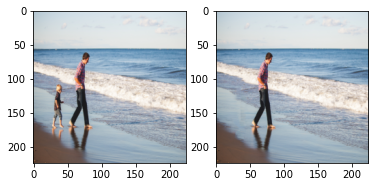

EfficientNet
sandbar: 33.95
seashore: 17.50
bikini: 4.14
swimming_trunks: 3.61
maillot: 2.36

sandbar: 33.71
seashore: 21.98
swimming_trunks: 2.71
bikini: 1.71
maillot: 1.58

--------------------



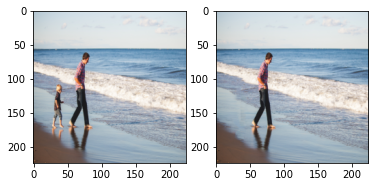

VGG19
nail: 22.83
sandbar: 14.31
seashore: 8.17
matchstick: 3.54
balance_beam: 3.03

nail: 19.89
sandbar: 19.83
seashore: 10.38
pole: 3.31
wreck: 3.25



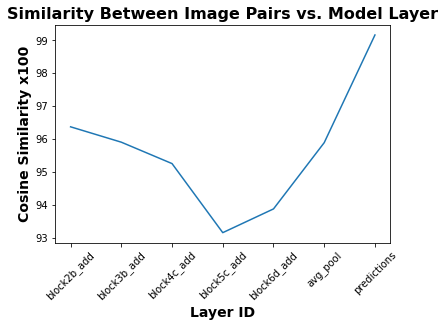

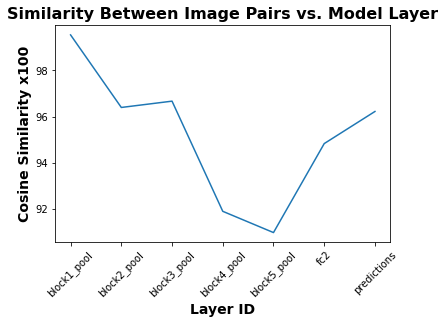

In [3]:
# display some sample image pairs

image_num = 15
img1_path = os.path.join(anchor_dir, anchor_fnames[image_num])
img2_path = os.path.join(manip_dir, manip_fnames[image_num])

img1_en = ie.Image(img1_path, B0_embeds)
img2_en = ie.Image(img2_path, B0_embeds)
img1_en.show_next_to(img2_en)
print("EfficientNet")
img1_en.print_top5()
img2_en.print_top5()

print("--------------------")
print("")

img1_vgg = ie.Image(img1_path, vgg19_embeds)
img2_vgg = ie.Image(img2_path, vgg19_embeds)
img1_vgg.show_next_to(img2_vgg)
print("VGG19")
img1_vgg.print_top5()
img2_vgg.print_top5()

ie.plot_similarities(B0_layers, ie.similarity_vs_layer(img1_en, img2_en))
plt.show()
ie.plot_similarities(vgg19_layers, ie.similarity_vs_layer(img1_vgg, img2_vgg))
plt.show()

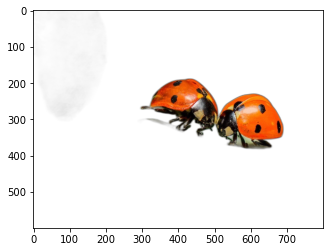

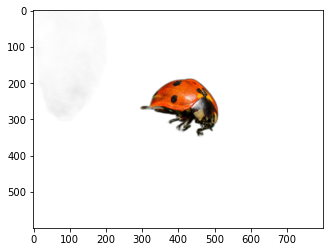

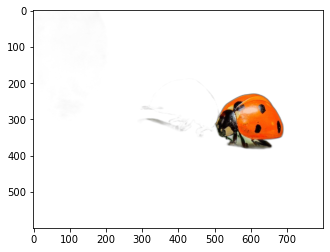

ladybug: 81.78
leaf_beetle: 1.62
black_widow: 0.33
jack-o'-lantern: 0.30
goldfish: 0.30



In [28]:
# load image into array
def load_img(img_path):
    img = cv2.imread(img_path)
    img = np.asarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return img

img = load_img("anchor\\15.jpeg")
output = remove(img)

img2 = load_img("manipulated\\m15.jpeg")
output2 = remove(img2)


plt.imshow(output)
plt.show()

plt.imshow(output2)
plt.show()

diff = cv2.absdiff(output2, output)
plt.imshow(diff)
plt.show()

cv2.imwrite("change/test.jpeg", cv2.cvtColor(diff, cv2.COLOR_RGB2BGR))

# # output the region of change between image pairs
def isolate_change(img1, img2):
    neg_mask = cv2.cvtColor(np.abs(img1-img2), cv2.COLOR_RGB2GRAY) > 0
    kernel = np.ones((5,5), np.uint8)
    neg_mask = cv2.erode(np.uint8(neg_mask), kernel, iterations=3)
    neg_mask = cv2.dilate(np.uint8(neg_mask), kernel, iterations=3)
    change = np.multiply(img1, np.expand_dims(neg_mask, axis=2))

    return change

for anchor_file, manip_file in zip(anchor_fnames, manip_fnames):
    id = anchor_file.split(".")[0]
    anchor_path = os.path.join(anchor_dir, anchor_file)
    manip_path = os.path.join(manip_dir, manip_file)
    
    anchor_img = load_img(anchor_path)
    manip_img = load_img(manip_path)
    change = isolate_change(anchor_img, manip_img)

    save_path = os.path.join("change", anchor_file)
    cv2.imwrite(save_path, change)

# temp = ie.Image("change/test.jpeg", B0_embeds)
# temp.print_top5()

adsfas

In [9]:
# saved format:
# anchor
# -- img_01
# -- -- block2b_add.npy
# -- -- block3b_add.npy
# -- -- ...
# -- img_02
# -- ...
# manipulated
# -- ...

def save_embeddings(save_dir, image_dir, image_fnames):
    for file in image_fnames:
        img_path = os.path.join(image_dir, file)
        img = ie.Image(img_path, B0_embeds)

        id = file.split(".")[0]
        save_folder = os.path.join(save_dir, f"img_{id}")

        if (not os.path.exists(save_folder)):
            os.mkdir(save_folder)

            for embed, layer_name in zip(img.embeddings, B0_layers):
                save_path = os.path.join(save_folder, layer_name)
                # pd.DataFrame(embed.numpy()).to_csv(save_path)
                np.save(save_path, embed)

save_embeddings("saved_embeddings\\manipulated", manip_dir, manip_fnames)

AlignedData is a struct with fields:

        Old: [1×1 struct]
    Removed: [1×1 struct]
      Added: [1×1 struct]
        Img: [1×1 struct]
      ImgID: {1024×1 cell}
      
AlignedData.Old ==> memorability scores for old images (repeated) \
AlignedData.Removed ==> memorability scores for Removed images (repeated) \
AlignedData.Added ==> memorability scores for Added images (repeated) \
AlignedData.ImgID ==> image ID

Added: manipulated, anchor \
Removed: anchor, manipulated \
Old: anchor, anchor


In [4]:
# remove extraneous dimensions from array
def fix_list(my_list):
    while len(my_list) == 1:
        my_list = my_list[0]

    return np.squeeze(np.array(my_list))

# unpack all data from .mat file
mem_scores = scipy.io.loadmat("AlignedData_28-Jan-2022.mat")
old = fix_list(mem_scores["AlignedData"]["Old"])
removed = fix_list(mem_scores["AlignedData"]["Removed"])
added = fix_list(mem_scores["AlignedData"]["Added"])
img_names = fix_list(mem_scores["AlignedData"]["ImgID"])
img_names = [x.item() for x in img_names]
print(len(img_names), len(anchor_fnames)) # not all images were used in the memorability test

# check that we have all the images corresponding to our memorability scores
for img in img_names:
    assert(img in anchor_fnames)
    assert("m"+img in manip_fnames)

d = {"img_name": img_names, "added": added, "removed": removed, "old": old}
mem_df = pd.DataFrame(d)

mem_df

1024 1036


,img_name,added,removed,old
0,01.jpeg,0.518519,0.622951,0.875000
1,02.jpeg,0.655172,0.696429,0.890625
2,03.jpeg,0.786885,0.705882,0.823529
3,04.jpeg,0.684211,0.894737,0.925926
4,05.jpeg,0.872340,0.927273,0.877193
...,...,...,...,...
1019,994.jpeg,0.830508,0.820000,0.816667
1020,995.jpeg,0.596491,0.739130,0.760000
1021,996.jpeg,0.709091,0.842105,0.877551
1022,997.jpeg,0.812500,0.740000,0.851064


Theory: \
Removed condition: higher memorability when the change has *higher* semantic similarity \
Added condition: higher memorability when the change as *lower* semantic similarity

In [15]:
anchor_saved_dir = "saved_embeddings\\anchor"
manip_saved_dir = "saved_embeddings\\manipulated"
semantic_sims = []

for img in img_names:
    id  = img.split(".")[0]

    anchor_path = os.path.join(anchor_saved_dir, f"img_{id}", "avg_pool.npy")
    anchor_embed = np.load(anchor_path)

    manip_path = os.path.join(manip_saved_dir, f"img_m{id}", "avg_pool.npy")
    manip_embed = np.load(manip_path)

    semantic_sims.append(ie.cosine_sim(anchor_embed, manip_embed))

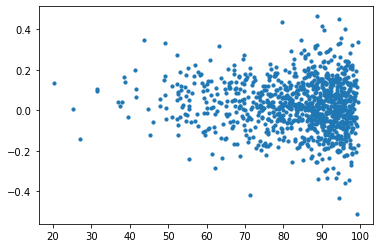

array([[ 1.        , -0.07378739],
       [-0.07378739,  1.        ]])

In [23]:
plt.scatter(semantic_sims, mem_df["added"]-mem_df["removed"], s=10)
plt.show()

np.corrcoef(semantic_sims, mem_df["added"]-mem_df["removed"])

# plt.scatter(semantic_sims, mem_df["removed"], s=10)
# plt.show()

In [ ]:
# construct training dataset

In [135]:
 # train an MLP on layer similarity scores and on concatenated semantic embeddings

class MemMLP(tf.keras.Model):
    def __init__(self, activation, num_layers):
        super().__init__()
        self.hidden = tf.keras.layers.Dense(num_layers//2, activation=activation)
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.hidden2 = tf.keras.layers.Dense(num_layers//4, activation=activation)
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.mem = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = self.hidden(inputs)
        x = self.dropout1(x)
        x = self.hidden2(x)
        x = self.dropout2(x)
        x = self.mem(x)
        return x

    def model(self):
        inputs = tf.keras.Input(shape=(1, 9408))
        return tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))

mem_mlp = MemMLP(activation="sigmoid", num_layers=9408)
mem_mlp.model().summary()
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
mem_mlp.compile(
    optimizer = opt,
    loss = "mse",
    metrics = ["mae"]
)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1, 9408)]         0         
_________________________________________________________________
dense_45 (Dense)             (None, 1, 4704)           44259936  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 4704)           0         
_________________________________________________________________
dense_46 (Dense)             (None, 1, 2352)           11066160  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 2352)           0         
_________________________________________________________________
dense_47 (Dense)             (None, 1, 1)              2353      
Total params: 55,328,449
Trainable params: 55,328,449
Non-trainable params: 0
______________________________________________

In [136]:
history = mem_mlp.fit(
    X_train,
    y_train, 
    batch_size = 4,
    shuffle = True,
    epochs = 15, 
    validation_split = 0.2,
)

Epoch 1/15
205/205 [==============================] - 1s 6ms/step - loss: 0.0509 - mae: 0.1749 - val_loss: 0.0074 - val_mae: 0.0709
Epoch 2/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0252 - mae: 0.1197 - val_loss: 0.0059 - val_mae: 0.0604
Epoch 3/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0172 - mae: 0.0992 - val_loss: 0.0070 - val_mae: 0.0647
Epoch 4/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0160 - mae: 0.1008 - val_loss: 0.0083 - val_mae: 0.0699
Epoch 5/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0170 - mae: 0.1038 - val_loss: 0.0092 - val_mae: 0.0740
Epoch 6/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0160 - mae: 0.1008 - val_loss: 0.0096 - val_mae: 0.0761
Epoch 7/15
205/205 [==============================] - 1s 5ms/step - loss: 0.0163 - mae: 0.1017 - val_loss: 0.0102 - val_mae: 0.0788
Epoch 8/15
205/205 [==============================] - 1s 5ms/step - loss: 0.

In [ ]:
# OLD CODE

from skimage import color

aug_img = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")(img)

def isolate_change(img1, img2): 
    kernel = np.ones((7,7), np.uint8)
    neg_mask = color.rgb2gray(np.abs(img1-img2)) > 10
    # closing fills in gaps in mask
    neg_mask = cv2.dilate(np.uint8(neg_mask), kernel, iterations=1)
    neg_mask = cv2.erode(np.uint8(neg_mask), kernel, iterations=1)
    plt.imshow(neg_mask, cmap="gray")
    plt.colorbar()
    plt.show()
    neg_img = np.multiply(img1, np.reshape(neg_mask, (224,224,1)))

    return neg_img

    col_names = ["img_name"] + B0_layers
sim_df = pd.DataFrame(columns=col_names)

for img in img_names:
    anchor_path = os.path.join(anchor_dir, img)
    manip_path = os.path.join(manip_dir, "m"+img)
    anchor_img = Image(anchor_path, B0_embeddings)
    manip_img = Image(manip_path, B0_embeddings)
    sim_vec = similarity_vs_layer(anchor_img, manip_img)
    sim_df.loc[len(sim_df.index)] = [img] + sim_vec

# plt.scatter(perceptual, semantic, c=mem_df["added"], s=10)
# plt.colorbar()
# plt.title("Added Condition")
# plt.xlabel("Perceptual Similarity")
# plt.ylabel("Semantic Similarity")
# plt.show()

# plt.scatter(perceptual, semantic, c=mem_df["removed"], s=5)
# plt.colorbar()
# plt.title("Removed Condition")
# plt.xlabel("Perceptual Similarity")
# plt.ylabel("Semantic Similarity")
# plt.show()